## 01MIAR - Actividad Final: Análisis de la crisis en el norte de Mozambique

### Tabla de contenidos

* [Introduccion](#introduccion)
* [Sección 1: Importar datos](#seccion1)
* [Sección 2: Exploración temporal del dataset](#seccion2)
* [Sección 3: Análisis descriptivo del conflicto](#seccion3)
* [Sección 4: Distribución geográfica del conflicto](#seccion3)
* [Sección 5: Conclusión final e información adicional](#seccion3)

### Introducción <a class="anchor" id="introduccion"></a>

El [Proyecto ACLED (Armed Conflict Location & Event Data Project)](https://acleddata.com) es un iniciativa no gubernamental de recopilación de datos desglosados, análisis y mapeo de crisis y conflictos a escala global. ACLED recopila las fechas, los actores, los lugares, las muertes y los tipos de todos los eventos de protesta y violencia política denunciados en África, Oriente Medio, América Latina y el Caribe, Asia Oriental, Asia Meridional, Asia Sudoriental, Asia Central y el Cáucaso, Europa y los Estados Unidos de América. El equipo de ACLED lleva a cabo análisis para describir, explorar y probar escenarios de conflicto, y hace que tanto los datos como el análisis estén abiertos al público para su uso gratuito.

En esté ejercicio, usaré el acceso libre que ACLED proporciona a través de su API a fin de obtener datos detallados sobre Mozambique y proceder a un análisis descriptivo que ayudará a identificar claramente la existencia y evolución de un conflicto armado en el norte de dicho país y proporcionar una visión más detallada de su magnitud y alcance.

#### Librerías utilizadas

In [1]:
#!pipenv install wordcloud

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# usaré este paquete para manipular el formato de la fecha en las gráficas
import matplotlib.dates as mdates
import seaborn as sns
# este ajuste para evitar unos warnings muy insidiosos al reasignar columnas sobre el mismo dataframe
pd.options.mode.chained_assignment = None
import requests
import io
from os import path
from wordcloud import WordCloud

### Sección 1: Importar datos <a class="anchor" id="seccion1"></a>

Establezco los parámetros para acceder a la API de ACLED solicitando únicamente los datos correspondients a Mozambique a través del código ISO del país, a fin de evitar la descarga de todos los datos a nivel mundial. Hago la una petición GET usando la librería `requests`, donde específico que se me devuelvan los datos en formato CSV. La respuesta de la API queda registrada en el objeto `response`, que en caso de éxito almacenará todo el volumen de datos solicitado al servicio REST de ACLED.

#### 1.1 Conexión a la API <a class="anchor" id="seccion1.1"></a>

In [3]:
# Parámetros de acceso a la API
ACLED_API_KEY = 'oG0dbVwOCZyYDocgwWp-'
email = 'ibagur@gmail.com'
ISO = '508' # código ISO de Mozambique

# Contruyo la url de petición a la API
url = 'https://api.acleddata.com/acled/read.csv?key=' + ACLED_API_KEY + '&email=' + email + '&iso=' + ISO + '&limit=0'

# Realizo la petición GET
response = requests.get(url)

# Compruebo si ha tenido éxito
if response:
  print('Petición con éxito.')
else:
  print('Petición con ERROR.')

Petición con éxito.


Uso el método `StringIO` de la librería `io` para leer directamente el *stream* desde el contenido `content`de mi objeto `response` y enviar la salida al método `read_csv` de Pandas, y así evito el paso de descargar el contenido como archivo csv y volverlo a leer desde Pandas.

*Nota: Al final de la sección incluiré de manera comentada una manera alternativa para descargar físicamente el archivo al disco y cargarlo desde Pandas. En cualquier caso el archivo se encuentra disponible dentro de la carpeta 'res'

#### 1.2 Exploración inicial <a class="anchor" id="seccion1.2"></a>

In [4]:
moz_data = pd.read_csv(io.StringIO(response.content.decode('utf-8')))

Examino la estructura y columnas de mi *dataframe*, que a priori son consistentes con la [estructura de datos de ACLED](https://acleddata.com/acleddatanew/wp-content/uploads/dlm_uploads/2019/01/ACLED_Codebook_2019FINAL.docx.pdf).

In [5]:
moz_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103 entries, 0 to 2102
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   data_id           2103 non-null   int64  
 1   iso               2103 non-null   int64  
 2   event_id_cnty     2103 non-null   object 
 3   event_id_no_cnty  2103 non-null   int64  
 4   event_date        2103 non-null   object 
 5   year              2103 non-null   int64  
 6   time_precision    2103 non-null   int64  
 7   event_type        2103 non-null   object 
 8   sub_event_type    2103 non-null   object 
 9   actor1            2103 non-null   object 
 10  assoc_actor_1     333 non-null    object 
 11  inter1            2103 non-null   int64  
 12  actor2            1878 non-null   object 
 13  assoc_actor_2     459 non-null    object 
 14  inter2            2103 non-null   int64  
 15  interaction       2103 non-null   int64  
 16  region            2103 non-null   object 


In [6]:
moz_data.sample(3)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
1687,8034346,508,MZM454,454,2014-03-17,2014,1,Battles,Armed clash,RENAMO: Mozambican National Resistance,...,Maringue,-17.9644,34.3906,2,AIM,National,Battle with RENAMO,0,1622068197,MOZ
1983,8038299,508,MZM123,123,2005-09-06,2005,1,Riots,Violent demonstration,Rioters (Mozambique),...,Mocimboa Da Praia,-11.3460,40.3522,1,IRIN,International,"12 killed overall, 47 injured",6,1622068205,MOZ
920,7687628,508,MZM1242,1242,2019-10-16,2019,1,Riots,Mob violence,Rioters (Mozambique),...,Aldeia Biri Biri,-14.7539,34.5467,2,Club Mozambique,National,"On Oct 16th, a Malawian man died while his fri...",1,1613499274,MOZ


#### 1.3 Accesso alternativo a los datos <a class="anchor" id="seccion1.3"></a>

* Método para descargar el CSV a disco y leerlo desde Pandas, o para leer directamente el CSV local (ya descargado):

In [7]:
# with open('res/acled_moz.csv', 'w+') as f:
#     f.write(response.text)
# acled_data = pd.read_csv('res/acled_moz.csv')

### Sección 2: Exploración temporal del dataset<a class="anchor" id="seccion2"></a>

#### 2.1 Rango temporal del dataset <a class="anchor" id="seccion2.1"></a>

El dataset incluye una serie temporal de datos sobre conflictos e incidentes armados o violentos registrados a lo largo de varios años. Voy a hacer una rápida comprabación de rango total de fechas cubiertas, a fin de refinar el análisis posteriormente:

In [8]:
# parseo la columna de fecha a tipo datetime
moz_data['parsed_event_date'] = pd.to_datetime(moz_data['event_date'])
# extraigo la fecha más antigua y la formateo para hacerla más legible
print('Fecha registro más antiguo: ' + moz_data.parsed_event_date.min().strftime("%d %b %Y"))
print('Fecha registro más reciente: ' + moz_data.parsed_event_date.max().strftime("%d %b %Y"))

Fecha registro más antiguo: 05 May 1997
Fecha registro más reciente: 28 May 2021


#### 2.2 Identificación de provincia en conflicto (I) <a class="anchor" id="seccion2.2"></a>

A continuación realizo una primera exploración del número total de incidentes en aquellas provincias donde se han registrado eventos a lo largo de todos estos años:

In [9]:
events_province_tbl = moz_data.groupby('admin1').agg(
    tot_events=('data_id','count'),
    tot_fatalities=('fatalities',sum)
).reset_index()
events_province_tbl['ratio'] = events_province_tbl['tot_fatalities']/events_province_tbl['tot_events']
display(events_province_tbl)

,admin1,tot_events,tot_fatalities,ratio
0,Cabo Delgado,1036,2906,2.805019
1,Gaza,37,3,0.081081
2,Inhambane,31,14,0.451613
3,Manica,100,89,0.890000
4,Maputo,65,27,0.415385
5,Maputo City,201,74,0.368159
6,Nampula,135,59,0.437037
7,Niassa,31,20,0.645161
8,Sofala,283,258,0.911661
9,Tete,102,37,0.362745


En un rápido vistazo, es evidente que el número de incidentes en la provincia de *Cabo Delgado* es anormalmente superios al resto de provincias. De hecho, en un rápido cálculo podemos comprobar como representa el **49%** de todos los eventos registrados:

In [10]:
# extraigo las filas correspondientes a la provincia de Cabo Delgado
cabo_data = moz_data[moz_data['admin1'] == 'Cabo Delgado']
ratio = 100*len(cabo_data)/len(moz_data)
print("Ratio: {:.0f}% de todos los incidentes reportados".format(ratio))

Ratio: 49% de todos los incidentes reportados


Un gráfico de barras ayudará a visualizar mejor la situación, en la que se aprecia muy claramente lo desproporción en incidentes registrados en Cabo Delgado con respecto al resto de provincias de las que fueron recogidos datos.

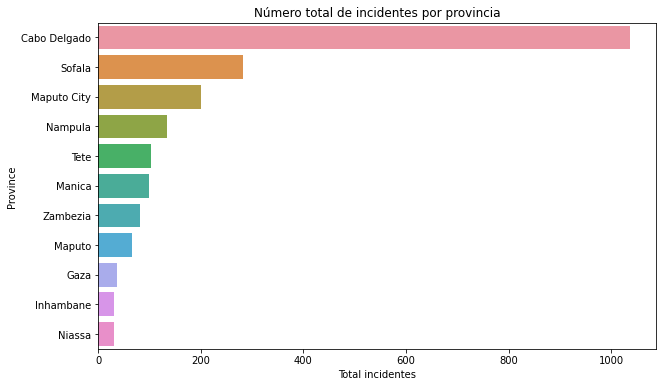

In [11]:
# reordeno el dataframe en función de la variable tot_events
events_province_tbl = events_province_tbl.sort_values(['tot_events'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(y = 'admin1', x = 'tot_events', data=events_province_tbl)
plt.ylabel('Province')
plt.xlabel('Total incidentes')
plt.title('Número total de incidentes por provincia')
plt.show()

#### 2.3 Identificación de provincia en conflicto (II) <a class="anchor" id="seccion2.3"></a>

Los tipos de incidentes, aunque de naturaleza conflictiva,  no necesariamente implican víctimas mortales. De hecho, como analizaré más adelante, la clasificación de ACLED abarca una amplio rango de incidentes de carácteristicas diversas. En cualquier caso, voy a realizar una análisis exploratorio multi-variable en el que compararé el número de total de incidentes en cada provincia con el número total de víctimas mortales reportadas y el ratio de víctimas mortales por incidente, lo cual puede darme una idea de la gravedad o escala de la situacion. Para ello creo un gráfico de dispersión (*scatterplot*) en el que una de las provincias, *Cabo Delgado*, destaca claramente tanto en volumen de incidentes como en su gravedad:

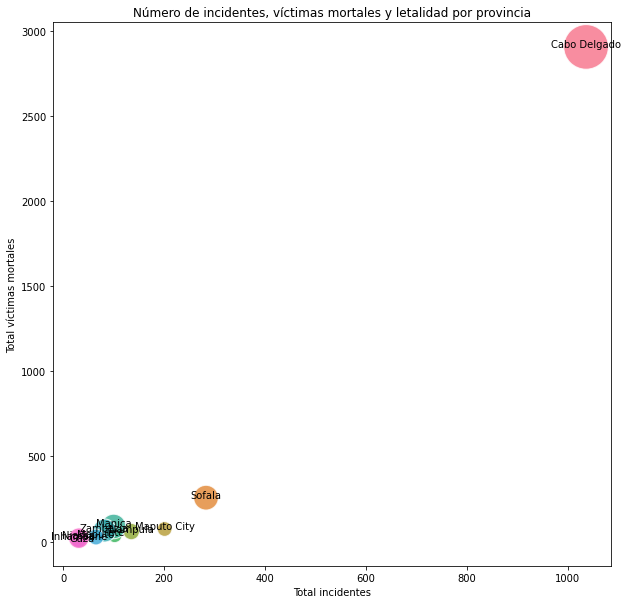

In [12]:
plt.figure(figsize=(10, 10))
g = sns.scatterplot(x="tot_events", y="tot_fatalities", 
                size="ratio", 
                data=events_province_tbl, 
                hue='admin1', 
                legend=False, 
                sizes=(10, 2000),
                alpha = .8)

plt.xlabel('Total incidentes')
plt.ylabel('Total víctimas mortales')

# añado los nombres de cada provincia sobre el marcador correspondiete
for i in range(events_province_tbl.shape[0]):
    plt.text(x=events_province_tbl.tot_events[i],
             y=events_province_tbl.tot_fatalities[i],
             s=events_province_tbl.admin1[i],
             horizontalalignment='center',
             size='medium')
plt.title('Número de incidentes, víctimas mortales y letalidad por provincia')
plt.show()

#### 2.4 Comparativa de la evolución de incidentes a lo largo del tiempo <a class="anchor" id="seccion2.4"></a>

Recojo en otro dataframe el resto de incidentes en Mozambique, excluyendo los acontecidos en Cabo Delgado (podría haber usado el operador lógico != pero he querido probar el método `isin`)

In [14]:
ex_cabo_data = moz_data[~moz_data.data_id.isin(cabo_data.data_id)]

Creo una tabla agregada por años, con el total de incidentes y víctimas mortales por año para todas las provincias del dataset, excluyendo *Cabo Delgado* (la provincia en la que hay indicios de conflicto):

In [15]:
ex_cabo_events_year_tbl = ex_cabo_data.groupby('year').agg(
    tot_events=('data_id','count'),
    tot_fatalities=('fatalities',sum)
).reset_index()

Compruebo el rango temporal:

In [16]:
ex_cabo_events_year_tbl.year.unique()

array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021])

Creo idéntica tabla agregada solo para los incidentes registrados en *Cabo Delgado*:

In [17]:
cabo_events_year_tbl = cabo_data.groupby('year').agg(
    tot_events=('data_id','count'),
    tot_fatalities=('fatalities',sum)
).reset_index()

Al comprobar su rango temporal, veo que no han sido registrados tantos años como en el reto de provincias.

In [18]:
cabo_events_year_tbl.year.unique()

array([1997, 2000, 2003, 2004, 2005, 2009, 2010, 2011, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021])

 Si quiero alinear las dos series temporales que quiero representar, tendré que crear *bins* vacías correspondientes a esos años no contabilizados en el dataset de *Cabo Delgado*. Para ello realizo una operación `merge` entre ambas tablas, pero usando un *outer join*, de tal manera que los años no presentes en la tabla 1 de *Cabo* (y que si aparecen en la tabla 2 del resto de provincias mozambicanas), se mostraran en el resultado del `merge` con valores *nan*. Finalmente sustituyo esos valores *nan* por 0:

In [19]:
cabo_events_year_full_tbl = pd.merge(cabo_events_year_tbl, 
                                     ex_cabo_events_year_tbl, 
                                     suffixes=("", "_y"), 
                                     how='outer', on='year', copy=False)\
                            .sort_values('year')\
                            .drop(['tot_events_y', 'tot_fatalities_y'], 1)\
                            .reset_index(drop=True)\
                            .fillna(0)

La nueva tabla de incidentes en *Cabo Delgado* contiene ahora el mismo rango de años que la tabla con los datos del resto de provincias con la que quiero compara la serie temporal en los gráficos que realizaré a continuación:

In [20]:
cabo_events_year_full_tbl.year.unique()

array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021])

Realizo un gráfico múltiple (combo) en el que combino por un lado la secuencia temporal de incidentes (en un *barplot*) y víctimas mortales (en un *line plot*) acontecidos en *Cabo Delgado* desde el comienzo del registro de datos en 1997 hasta la actualidad. Comparo esta serie temporal con un gráfico múltiple idéntico en rango temporal, pero sobre los incidentes y víctimas en **todo el resto de provincias**. Se puede comprobar de manera clara el comienzo de una situación de conflicto en 2017, con una rápida escalada tanto en el número de incidenes como de víctimas mortales, que continúa hasta la fecha:

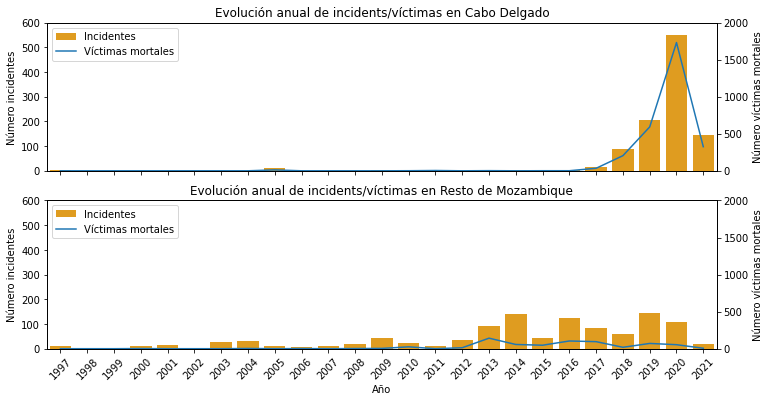

In [21]:
# creo una rejilla de figuras 2x1
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,6), sharey=True)

# establezco límites de ejes comunes para ambas figures
ax1.set(xlim=(1997, 2021), ylim=(0, 600))
ax2.set(xlim=(1997, 2021), ylim=(0, 600))

# creo el gráfico de barras de Cabo Delgado
ax1=sns.barplot(ax=ax1, 
            x = 'year', 
            y = 'tot_events', 
            color = 'orange', 
            data=cabo_events_year_full_tbl,
            label='Incidentes')

# Duplico el axis para crear un eje X común
ax1b = ax1.twinx()

# por alguna razón si uso Seaborn 'lineplot', no me deja hacer el combo así que uso 'plot' directamente
ax1b = cabo_events_year_full_tbl['tot_fatalities'].plot(kind='line', 
                                                        secondary_y=True, 
                                                        ax=ax1b, 
                                                        label='Víctimas mortales')
# límites para el eje y del gráfico lineplot
ax1b.set(ylim=(0, 2000))

# creo el segundo gráfico de barrar para el resto de provincias combinadas
ax2=sns.barplot(ax=ax2, 
            x = 'year', 
            y = 'tot_events', 
            color = 'orange', 
            data=ex_cabo_events_year_tbl)

# eje X común para el segundo gráfico del combo
ax2b = ax2.twinx()

# por alguna razón si uso Seaborn lineplot, no me deja hacer el combo
ax2b = ex_cabo_events_year_tbl['tot_fatalities'].plot(kind='line', 
                                                      secondary_y=True, 
                                                      ax=ax2b)
# límites para el eje y del gráfico lineplot
ax2b.set(ylim=(0, 2000))
# diversos ajustes y eticado en los ejes
ax1.set_xlabel('')
ax1.set_ylabel('Número incidentes')
ax1.set_xticklabels(labels = '')
ax1.set_title('Evolución anual de incidents/víctimas en Cabo Delgado')
ax2.set_ylabel('Número incidentes')
ax2.set_xlabel('Año')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
ax2.set_title('Evolución anual de incidents/víctimas en Resto de Mozambique')
ax1b.set_ylabel('Número víctimas mortales')
ax2b.set_ylabel('Número víctimas mortales')

# recojo las etiquetas para las leyendas de cada subplot
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')
# recojo las etiquetas para las leyendas de cada subplot
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

#### 2.5 Evolución mensual de incidentes en Cabo Delgado en el período de conflicto <a class="anchor" id="seccion2.5"></a>

Filtro los eventos ocurridos en Cabo Delgado a partir de 2017 hasta la actualidad:

In [22]:
cabo_conflict_data = cabo_data[cabo_data['year']>=2017]

Agrego mensualmente los datos de incidentes y víctimas mortales, usando el metodo `Grouper`de *Pandas* y el parámetro `freq`:

In [23]:
cabo_conflict_monthly_tbl = cabo_conflict_data\
    .groupby(pd.Grouper(key='parsed_event_date', freq='M'))\
    .agg(
        tot_events=('data_id','count'),
        tot_fatalities=('fatalities',sum)
    )\
    .reset_index()\
    .rename(columns={'parsed_event_date':'date'})


Aplico `map` sobre la columna de meses a fin de formatear la fecha de una manera legible en el gráfico (i.e 'Feb 2017', etc.):

In [24]:
cabo_conflict_monthly_tbl['month'] = cabo_conflict_monthly_tbl['date'].map(lambda a: a.strftime("%b %Y"))


In [25]:
cabo_conflict_monthly_tbl.head()

,date,tot_events,tot_fatalities,month
0,2017-02-28,1,1,Feb 2017
1,2017-03-31,0,0,Mar 2017
2,2017-04-30,0,0,Apr 2017
3,2017-05-31,0,0,May 2017
4,2017-06-30,0,0,Jun 2017


Realizo el combo de la serie temporal del mismo modo que en el apartado anterior, aunque ahora mostrando de manera detallada la evolución mensual en *Cabo Delgado* desde el comienzo de la situación de conflicto en 2017:

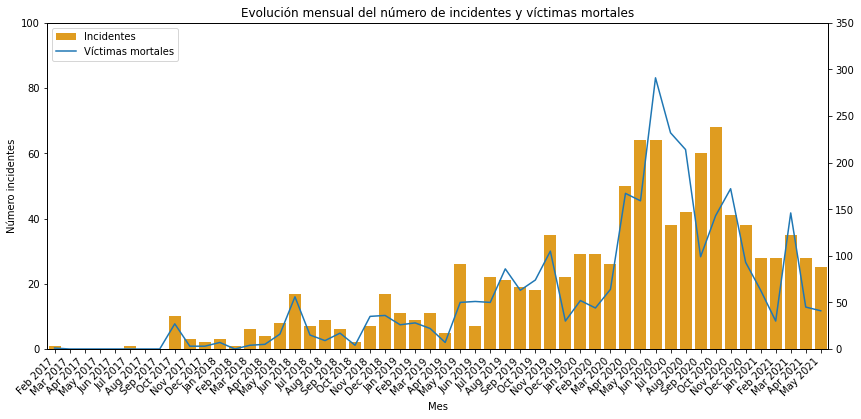

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize=(14,6))
ax1.set(xlim=(2017, 2021), ylim=(0, 100))
# creo un objeto dateformat para formatear el eje x con las fechas
#myFmt = mdates.DateFormatter('%Y-%m')
# aplico el formateo a las etiquetas del eje x
#ax.xaxis.set_major_formatter(myFmt)
ax1=sns.barplot(ax=ax1, 
            x = 'month', 
            y = 'tot_events', 
            color = 'orange',
            label='Incidentes',
            data=cabo_conflict_monthly_tbl)

ax2 = ax1.twinx()

# por alguna razón si uso Seaborn lineplot, no me deja hacer el combo
ax2 = cabo_conflict_monthly_tbl['tot_fatalities'].plot(kind='line', 
                                                       secondary_y=True, 
                                                       ax=ax2,
                                                       label='Víctimas mortales')
ax2.set(ylim=(0, 350))
# roto las etiquetas para que se vean mejor
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45, ha='right')
ax1.set_ylabel('Número incidentes')
ax1.set_xlabel('Mes')

# recojo las etiquetas para las leyendas de cada subplot
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')
#plt.xticks(rotation = 45, ha='right')
plt.title('Evolución mensual del número de incidentes y víctimas mortales')
plt.show()

#### 2.6 Conclusiones preliminares <a class="anchor" id="seccion2.6"></a>

A modo de resumen, gracias a este análisis preliminar se pueden establecer los siguientes hechos:
1. Prácticamente la mitad de los incidentes registrados en Mozambique han tenido lugar en la provincia de *Cabo Delgado*
2. Si bien no todos los incidentes implican necesaramiente víctimas mortales, es evidente que aquellos que tuvieron lugar en *Cabo Delgado* conllevaron un índice mortandad asociada más alta, con lo que se deduce que en ese sentido fueron más graves.
3. La práctica totalidad de incidentes en *Cabo Delgado* ha tenido lugar en el período que va desde 2017 hasta la actualidad, lo que indica que el comienzo de una situación a partir de esa fecha, en contraposición con el resto del país donde si bien ha habido incidentes, su número es mucho menor y parece estar más uniformemente distribuido a lo largo de los años.
4. En base a lo anterior, no es aventurado suponer que un algún tipo conflicto violento y/o armado pueda está teniendo lugar en esa provincia.

### Sección 3: Análisis descriptivo del conflicto <a class="anchor" id="seccion3"></a>

#### 3.1 Identificación de incidentes más comunes <a class="anchor" id="seccion3.1"></a>

Un exploración rápida del dataset específico de *Cabo Delgado* me muestra los principales grupos de incidentes en los que se basa la clasificación de ACLED (el [documento de estructura de datos de ACLED](https://acleddata.com/acleddatanew/wp-content/uploads/dlm_uploads/2019/01/ACLED_Codebook_2019FINAL.docx.pdf) proporciona una explicación más detallada de lo que englobaría cada grupo). Es quizás demasiado genérico para realizar un análisis en detalle:

In [27]:
cabo_conflict_data.event_type.unique()

array(['Strategic developments', 'Battles', 'Riots',
       'Violence against civilians', 'Explosions/Remote violence',
       'Protests'], dtype=object)

Si paso al nivel inferior de la categoría, `sub_event_type`, veo ya que la descripción del tipo de incidente me puede dar una visión más clara de su tipología y ayuda a identificar mejor aquellos incidentes más asociados a un conflicto armado como puedan ser ataques con armas pesadas, destrucción de propiedad o violaciones de derechos humanos (incluída violencia sexual o desapariciones forzadas):

In [28]:
cabo_conflict_data.sub_event_type.unique()

array(['Looting/property destruction', 'Armed clash',
       'Government regains territory', 'Mob violence',
       'Non-violent transfer of territory', 'Attack',
       'Abduction/forced disappearance', 'Disrupted weapons use', 'Other',
       'Shelling/artillery/missile attack', 'Air/drone strike',
       'Non-state actor overtakes territory', 'Change to group/activity',
       'Sexual violence', 'Protest with intervention',
       'Violent demonstration', 'Arrests', 'Agreement',
       'Peaceful protest'], dtype=object)

Creo una tabla agregada con el total de incidentes y víctimas mortales asociada a cada subtipo de incidente:

In [29]:
cabo_sub_event_type_tbl = cabo_conflict_data\
    .groupby('sub_event_type')\
    .agg(
    tot_events=('data_id','count'),
    tot_fatalities=('fatalities',sum)
    ).reset_index()

Selecciono los 5 tipos de incidentes más frecuentes y genero un gráfico ordenado de barras. Se aprecia claramente que los incidentes más comunes están muy vinculados a la existencia de un conflicto armado.

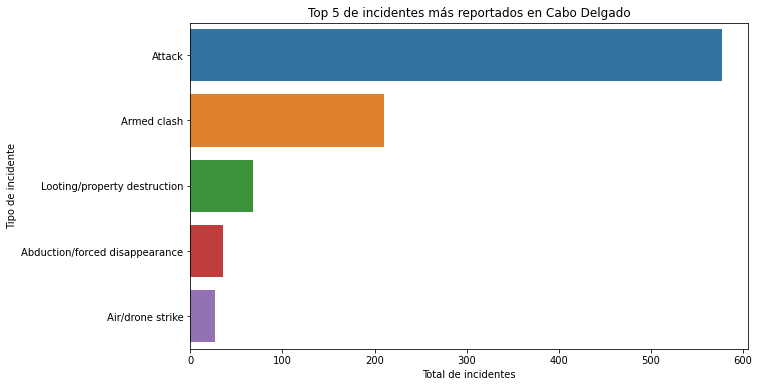

In [30]:
# reordeno el dataframe en función de la variable tot_events
cabo_sub_event_type_top_tbl = cabo_sub_event_type_tbl\
    .sort_values(['tot_events'], ascending=False)\
    .reset_index(drop=True)\
    .nlargest(5,'tot_events')

plt.figure(figsize=(10, 6))
sns.barplot(y = 'sub_event_type', x = 'tot_events', data=cabo_sub_event_type_top_tbl)
plt.xlabel('Total de incidentes')
plt.ylabel('Tipo de incidente')
plt.title('Top 5 de incidentes más reportados en Cabo Delgado')
plt.show()

#### 3.2 Grado de letalidad de los incidentes más comunes <a class="anchor" id="seccion3.2"></a>

Calculo el ratio de letalidad según el tipo de incidente:

In [31]:
cabo_sub_event_type_top_tbl['ratio_lethal'] = cabo_sub_event_type_top_tbl['tot_fatalities']/cabo_sub_event_type_top_tbl['tot_events']

Mostraré ahora un *scatterplot* multivariable, con el número total de incidentes y víctimas mortales para cada tipo de los incidentes más reportados, así como la letalidad de cada tipo de incidente (represantada por el tamaño del círculo). En este caso realizo el gráfico ultilizando `matplotlib` directamente, ya que me permitirá manipular la leyenda del gráfico de una manera más directa que con `seaborn` (quiero mostrar únicamente los tipos de incidente y no la variable `size`):

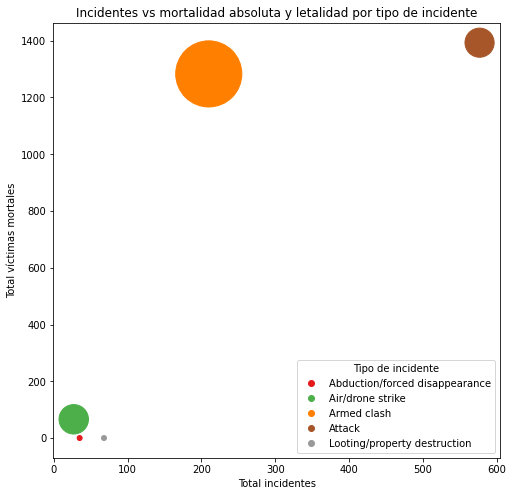

In [32]:
# transformo la columna 'sub_event_type' a tipo categórico
cabo_sub_event_type_top_tbl['sub_event_type'] = cabo_sub_event_type_top_tbl['sub_event_type'].astype("category")

# creo una columna numérica auxiliar para el mapa de colores según categoría
cabo_sub_event_type_top_tbl['sub_event_type_int'] = cabo_sub_event_type_top_tbl['sub_event_type'].cat.codes

# creo una columna numérica auxiliar para poder representar mejor el tamaño del circulo según el ratio_lethal
cabo_sub_event_type_top_tbl['ratio_lethal_int'] = (cabo_sub_event_type_top_tbl['ratio_lethal']*10+5)**2

plt.figure(figsize=(8, 8))
sc = plt.scatter(x="tot_events", 
                 y="tot_fatalities", 
                 s="ratio_lethal_int", 
                 c="sub_event_type_int", 
                 data = cabo_sub_event_type_top_tbl, 
                 cmap="Set1")
# creo la leyenda que corresponde únicamente a la variable categórica 'sub_event_type'
leg1 = plt.legend(sc.legend_elements("colors")[0], 
                  cabo_sub_event_type_top_tbl['sub_event_type'].cat.categories,
                  title="Tipo de incidente", 
                  loc="lower right")
plt.xlabel('Total incidentes')
plt.ylabel('Total víctimas mortales')
plt.title("Incidentes vs mortalidad absoluta y letalidad por tipo de incidente")
plt.show()

#### 3.3 Distribución temporal según tipo de incidente <a class="anchor" id="seccion3.3"></a>

Voy a estudiar la distribución temporal de los tipos de incidentes a lo largo del período del conflicto, agregando los datos por trimestre. Utilizo `dt.to_period` para convertir la columna con la fecha `parsed_event_date` a formato de *trimestre*

In [33]:
cabo_conflict_data['quarter'] = cabo_conflict_data['parsed_event_date'].dt.to_period("Q")

Agrupo la totalidad de incidentes y víctimas mortales por trimestre y tipo de incidente:

In [34]:
cabo_quarter_sub_event_type_tbl = cabo_conflict_data\
    .groupby(['quarter','sub_event_type'])\
    .agg(
        tot_events=('data_id','count'),
        tot_fatalities=('fatalities',sum)
    )\
    .reset_index()

Anteriormente calculé los 5 tipos más numeros de incidentes. Haciendo un *right join* con la tabla de incidentes por trimestre, obtengo las filas de la tabla trimestral donde el tipo de incidente pertenezca a ese subconjunto:

In [35]:
cabo_quarter_sub_event_type_top_tbl = pd.merge(cabo_quarter_sub_event_type_tbl, 
                                     cabo_sub_event_type_top_tbl, 
                                     suffixes=("", "_y"), 
                                     how='right', on='sub_event_type', copy=False)\
                            .sort_values('quarter')\
                            .drop(['tot_events_y', 'tot_fatalities_y'], 1)\
                            .reset_index(drop=True)\
                            .fillna(0)

Construyo una tabla pivot, que me servirá de entrada para construir el *heatmap*:

In [36]:
cabo_quarter_sub_event_type_top_tbl_wide = cabo_quarter_sub_event_type_top_tbl\
    .pivot_table(index='sub_event_type',
                 columns='quarter',
                 values='tot_events')

Construyo un *heatmap* que me muestra la distribución trimestral para cada tipo de los incidentes más comunes durante el período del conflicto (2017 a la actualidad):

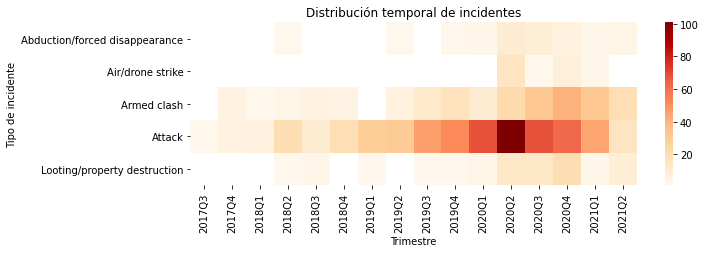

In [37]:
plt.figure(figsize=(10, 3))
sns.heatmap(cabo_quarter_sub_event_type_top_tbl_wide, cmap="OrRd")
#plt.xticks(rotation = 45, ha='right')
plt.title('Distribución temporal de incidentes')
plt.xlabel('Trimestre')
plt.ylabel('Tipo de incidente')
plt.show()

#### 3.4 Estudio de las partes involucradas en los incidentes <a class="anchor" id="seccion3.4"></a>

Estudiaré ahora el tipo de interacción entre las partes involucradas en un evento. Dicha interacción lleva asociado un código numérico almacenado en la variable `interaction`. Agrupo el número de incidentes y víctimas según el tipo de interacción violenta:

In [38]:
cabo_interaction_code_tbl = cabo_conflict_data\
    .groupby(['interaction'])\
    .agg(
        tot_events=('data_id','count'),
        tot_fatalities=('fatalities',sum)
    )\
    .reset_index()

Necesito ahora leer y cargar en un dataframe el *dataset* que contiene la tabla de referencia para los diferentes códigos numéricos:

In [39]:
interaction_codes_path = path.join("res", "interaction_codes.csv")
interaction_codes = pd.read_csv(interaction_codes_path)

Realizo un `merge` mediante `left_join` a fin de obtener la descripción asociada a cada código de interacción, y selecciono las 5 interacciones más reportadas:

In [40]:
cabo_interaction_fatalities_top_tbl = pd.merge(
    cabo_interaction_code_tbl,
    interaction_codes,
    suffixes=("", "_y"),
    how='left',
    left_on='interaction',
    right_on='code',
    copy=False)\
.drop(['interaction', 'code'], 1)\
.rename(columns={'interaction_y':'interaction'})\
.dropna()\
.nlargest(5,'tot_fatalities')\
.sort_values(['tot_fatalities'], ascending=False)

Un gráfico de barras mostrará más claramente el número de víctimas según la interacción violenta. En este caso el mayor número de víctimas mortales es debido tanto a enfrentamientos del Ejército de Mozambique contra las Milicias Islamistas como a ataques de las Milicias Islamistas a la población civil:

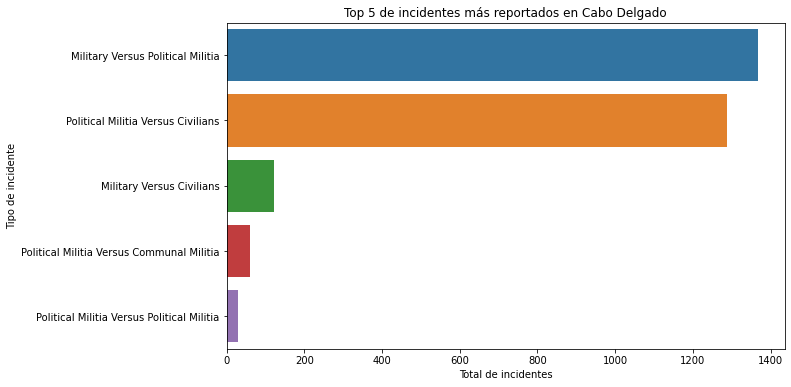

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(y = 'interaction', x = 'tot_fatalities', data=cabo_interaction_fatalities_top_tbl)
plt.xlabel('Total de incidentes')
plt.ylabel('Tipo de incidente')
plt.title('Top 5 de incidentes más reportados en Cabo Delgado')
plt.show()

#### 3.4 Identificación de los actores principales en conflicto <a class="anchor" id="seccion3.4"></a>

La columna `actor1` del *dataset* original contiene la información sobre el partícipe directo en el incidente violento. Usando la librería `wordcloud` hago un rápido análisis cualitativo del texto contenido en esa columna para todo el conjunto de incidentes acontecidos en *Cabo Delgado*. Dicho análisis no proporciona un resultado cuantitativo pero aporta un interesante impacto visual. En este caso los actores más involucrados en los incidentes fueron identificados como Milicias Islamistas y en menor medida las propias fuerzas del Ejército (en calidad de contra-atacantes, aunque se reporta también ataques a la población civil por parte de dichas fuerzas):

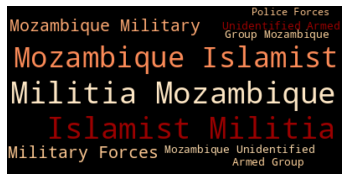

In [42]:
wc = WordCloud(min_font_size=5,max_words=10,colormap="OrRd").generate(' '.join(cabo_conflict_data['actor1']))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

### Sección 4: Distribución geográfica del conflicto <a class="anchor" id="seccion4"></a>

#### 4.1 Importación de datos GIS <a class="anchor" id="seccion4.1"></a>

Para ir finalizando, mostraré en mapa de *Cabo Delgado*, la distribución absoluta de incidentes a nivel de distrito. Eso me permitirá identificar aquellos distritos más afectados y de los que miles de personas afectadas han sufrido desplacimiento forzoso a otros distritos más seguros. A fin de no alargar el análisis, no entraré en el análisis de desplazados internos, ya que ellos requeriría trabajar con otro *dataset* de la [Organización Internacional para las Migraciones (OIM)](https://www.iom.int), la cual suele proporcionar dichos datasets a través de su iniciativa [DTM (Displacement Tracking Matrix)](https://displacement.iom.int). Lo que si haré será incluir a modo de conclusión un gráfico obtenido en mi trabajo habitual en donde se puede ver como los distritos de donde está huyendo la gente, coinciden en buena medida con aquellos con más cantidad de incidentes (algo que era de esperar).

Usando la librería `geopandas`, leeré el archivo `geojson` que contiene los datos geográficos de la provincia de *Cabo Delgado* y su división administrativa por *distritos*. Dichos archivos GIS, conocidos en el ámbito de información humanitaria como CODs (Common Operational Datasets) se encuentran públicamente disponibles desde la web de [Humanitarian Data Exchange](https://data.humdata.org) en diversos formatos. Tras cargar la información geográfica del archivo en un *dataframe* de *Geopandas*, realizo una proyección a un sistema de coordenadas de *quasi* igual área (Universal Transverse Mercator), en este caso a la zona UTM 36S que abarcaría Mozambique, ya que el archivo GIS original usaba un proyección geodética (latitud, longitud).

In [43]:
gdf = gpd.read_file('res/cabo_admin2.geojson')
# conversion a sistema de coordenadas UTM 36S
gdf = gdf.to_crs(epsg=5629)

Exploro superficialmente los campos del archivo GIS. El campo `ADM2_PT` contiene el nombre de los distritos de *Cabo Delgado* en portugués (en Mozambique, el siguiente nivel administrativo tras la provincia, es el distrito):

In [44]:
gdf.head(3)

,Shape_Leng,Shape_Area,ADM2_PT,ADM2_PCODE,ADM2_REF,ADM2ALT1PT,ADM2ALT2PT,ADM1_PT,ADM1_PCODE,ADM0_EN,ADM0_PT,ADM0_PCODE,date,validOn,validTo,geometry
0,3.762392,0.410000,Ancuabe,MZ0101,None,None,None,Cabo Delgado,MZ01,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,None,"MULTIPOLYGON (((-29908.378 8603295.723, -29919..."
1,4.065989,0.458926,Balama,MZ0102,None,None,None,Cabo Delgado,MZ01,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,None,"MULTIPOLYGON (((-200290.428 8562532.719, -2001..."
2,4.431364,0.448459,Chiure,MZ0103,None,None,None,Cabo Delgado,MZ01,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,None,"MULTIPOLYGON (((-94612.375 8534362.091, -94457..."


#### 4.2 Preparación de datos GIS <a class="anchor" id="seccion4.2"></a>

Agrupo en un dataframe el total de incidentes y víctimas mortales por distrito, ya que a continuación realizaré un *merge* con el *dataframe* de *Geopandas*. Corrijo un pequeño error tipográfico en el nombre del distrito de *Mocimboa Da Praia*, para que coincida con el nombre de ese distrito en el *dataframe* de *Geopandas* durante el `merge`:

In [45]:
cabo_district_tbl = cabo_conflict_data\
    .groupby(['admin2'])\
    .agg(
        tot_events=('data_id','count'),
        tot_fatalities=('fatalities',sum)
    )\
    .reset_index()

# reemplazo el nombre del distrito por el correcto
cabo_district_tbl['admin2'][cabo_district_tbl['admin2'] == 'Mocimboa da Praia'] = 'Mocimboa Da Praia'

A continuación hago un `merge` *left join* del *dataframe Geopandas* con el *dataframe* anterior, a fin de añadir las columnas `tot_events` y `tot_facilities`:

In [46]:
cabo_district_gdf = pd.merge(
    gdf,
    cabo_district_tbl,
    suffixes=("", "_y"),
    how='left',
    left_on='ADM2_PT',
    right_on='admin2',
    copy=False)\
.drop('admin2',1)\
.fillna(0)

#### 4.3 Creación de mapas descriptivos <a class="anchor" id="seccion4.3"></a>

Construyo dos mapas *coropléticos* en función del número de incidentes por distrito y del número de víctimas. En ambos mapas se aprecia que el distrito más afectado es *Mocimboa Da Praia*, seguido de *Macomia*, *Muidumbe* y *Quissanga* en menor medida. De hecho *Mocimboa Da Praia* fue ocupado por las milicias de ISIS en 2020 y en la actualidad se encuentra fuera del control gubernamental y del alcance de la ayuda humanitaria ([Key Mozambique port 'seized by IS'](https://www.bbc.com/news/world-africa-53756692))

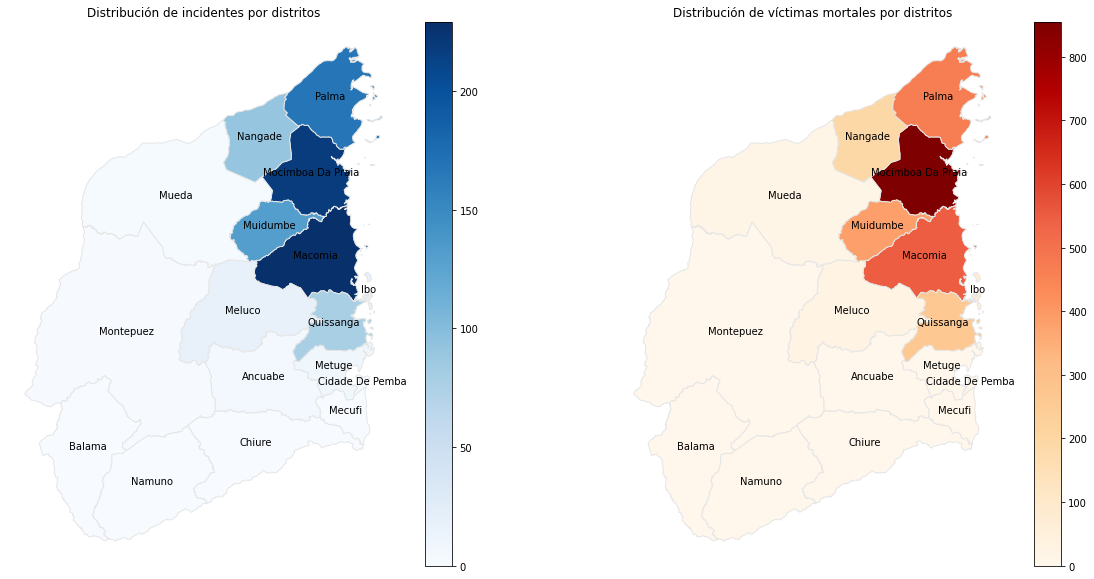

In [47]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1 = cabo_district_gdf.plot(column='tot_events', cmap='Blues', linewidth=1, ax=ax1, edgecolor='0.9', legend = True)
ax2 = cabo_district_gdf.plot(column='tot_fatalities', cmap='OrRd', linewidth=1, ax=ax2, edgecolor='0.9', legend = True)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Distribución de incidentes por distritos')
ax2.set_title('Distribución de víctimas mortales por distritos')
cabo_district_gdf.apply(lambda x: ax1.annotate(text=x.ADM2_PT, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
cabo_district_gdf.apply(lambda x: ax2.annotate(text=x.ADM2_PT, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

plt.show()

### Sección 5: Conclusión final e información adicional <a class="anchor" id="seccion4"></a>

El [conflicto en el Norte de Mozambique](https://en.wikipedia.org/wiki/Insurgency_in_Cabo_Delgado) en efecto estalló en 2017 y continúa en la actualidad, tal como se ha podido comprobar en el estudio descriptivo hecho en este ejercicio. Dicho conflicto está en el foco de una grave crisis humanitaria (agravada por otro lado por periódicos desastres naturales como ciclones), que hasta la fecha ha causado casi 700,000 desplazados internos. Dichos desplazados proceden en buena puerta de los distritos más afectados por el conflicto, como *Mocimboa Da Praia* o *Muidambe*, o distritos adyacentes que actúan como 'distritos de paso' como *Quissanga*, tal como se aprecia en este gráfico de cuerdas que he querido incluir a modo de ejemplo (originalmente generado con R a partir de datos de desplazamiento interno de la [Organización Internacional para las Migraciones](https://displacement.iom.int):

<img src="https://i.imgur.com/cPW7Knl.png">

Algunos enlaces con información sobre el conflicto en el norte de Mozambique: 
* [Insurgencia islamista en el norte de Mozambique](https://en.wikipedia.org/wiki/Insurgency_in_Cabo_Delgado)
* [Cabo Delgado: el olvidado norte de Mozambique donde el terrorismo encarna la maldición de los recursos](https://www.esglobal.org/cabo-delgado-el-olvidado-norte-de-mozambique-donde-el-terrorismo-encarna-la-maldicion-de-los-recursos/)
* [24 horas en Mozambique. La emergencia de Cabo Delgado](https://elpais.com/sociedad/vidas-nuevas/2021-05-24/24-horas-en-mozambique-la-emergencia-de-cabo-delgado.html)